In [3]:
# パラメータ
d = 11
n = (d + 1) / 2  # n = 3
n = int(n)

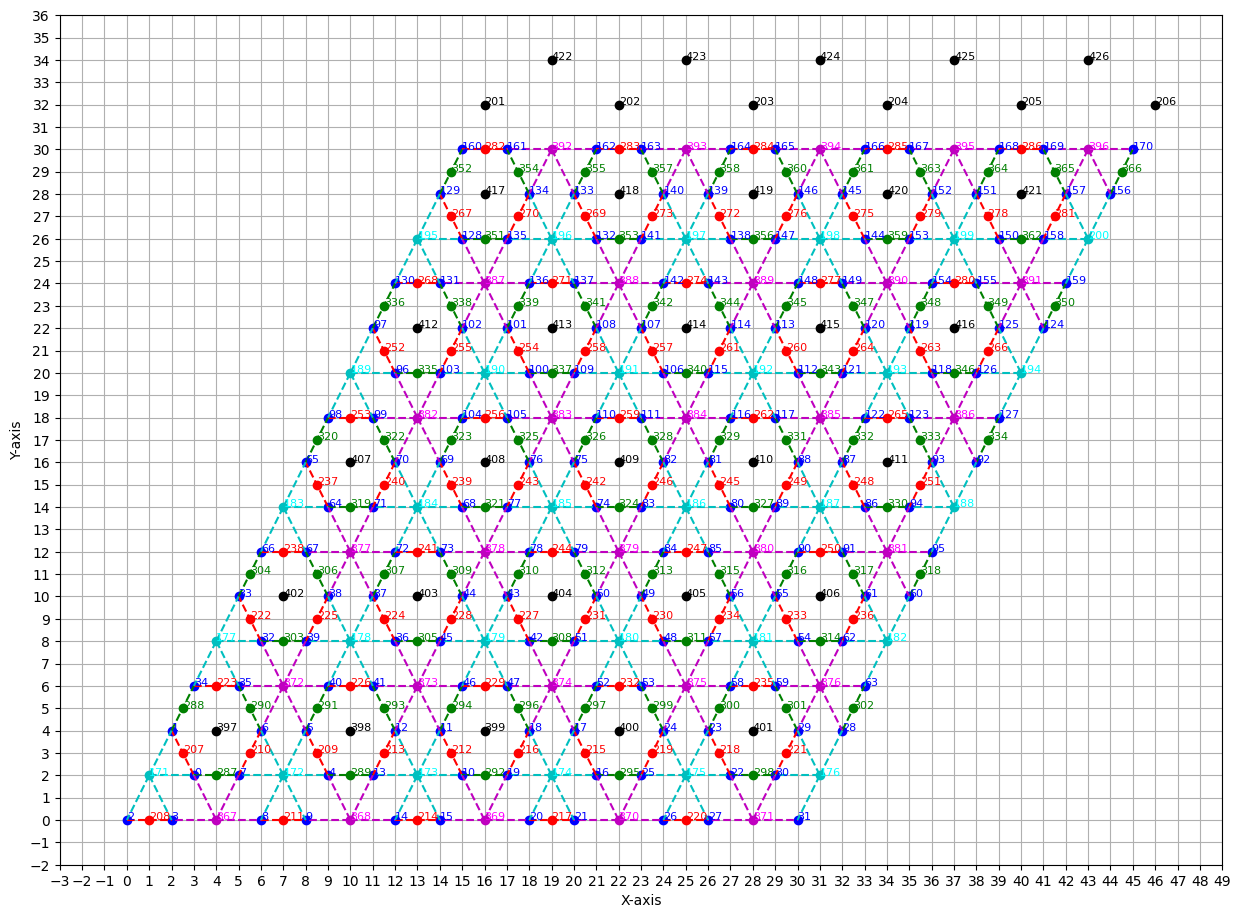

In [4]:
import math
import matplotlib.pyplot as plt


shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成毎 (最初のブロック)の(direction,生成data qubit index)記録

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

# --- 最初のブロック(ancilla + data生成) ---
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        # Ancilla登録
        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# data, ancilla辞書の初期構築
data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# green_X_face: 最初のブロックで生成されたancillaについてdirection_mapから取得
green_X_face = {}
for i, record in enumerate(direction_map):
    ancilla_index = ancilla_qubit_dict_start + i
    green_X_face[ancilla_index] = [(dx, dy, di) for (dx, dy, di) in record]

# blue_Z_edge生成
blue_Z_edge = {}
for ancilla_num, record in enumerate(direction_map):
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# green_X_edge生成 (最初のブロック)
green_X_edge = {}
num_first_block_ancillas = len(initial_base_points)*n
first_block_ancillas = ancilla_qubits[:num_first_block_ancillas]

for i in range(num_first_block_ancillas):
    for j in range(i+1, num_first_block_ancillas):
        x1,y1 = first_block_ancillas[i]
        x2,y2 = first_block_ancillas[j]
        dx = x2 - x1
        dy = y2 - y1
        dist = math.sqrt(dx*dx + dy*dy)
        if abs(dist - 6) < 1e-9 or abs(dist - 3*math.sqrt(5)) < 1e-9:
            selected_data = []
            for d_i,(xd,yd) in data_qubit_dict.items():
                if (xd == x1 and yd == y1) or (xd == x2 and yd == y2):
                    continue
                if abs(dx*(yd - y1) - dy*(xd - x1)) < 1e-9:
                    if min(x1,x2) <= xd <= max(x1,x2) and min(y1,y2) <= yd <= max(y1,y2):
                        selected_data.append(d_i)
            if len(selected_data) == 2:
                B,Bp = selected_data
                mid_x = (x1+x2)/2.0
                mid_y = (y1+y2)/2.0
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (mid_x, mid_y)
                green_X_edge[A_index] = (B,Bp)

# ===== 重複アンシラ削除 =====
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [idx for idx in all_qubits_dict if idx >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        duplicates[A] = coord_to_ancilla_index[coord]

for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in blue_Z_edge:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

for A in list(green_X_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in green_X_edge:
            green_X_edge[new_A] = green_X_edge[A]
        del green_X_edge[A]

for A in duplicates.keys():
    del all_qubits_dict[A]

# (4,0,n)
base_sets_400n = [
    (4,0,n),
]

before_400n_count = len(all_qubits_dict)
for (bx, by, steps) in base_sets_400n:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

after_400n_count = len(all_qubits_dict)
added_ancillas_400n = [idx for idx in range(before_400n_count, after_400n_count)]

# blue_Z_face作成 (4,0,n)で生成されたアンシラのみ対象)
blue_Z_face = {}
for A_index in added_ancillas_400n:
    ax, ay = all_qubits_dict[A_index]
    found_list = []
    for (dx, dy) in directions:
        tx, ty = ax + dx, ay + dy
        for di,(xd,yd) in data_qubit_dict.items():
            if xd == tx and yd == ty:
                found_list.append(((dx,dy), di))
                break
    if len(found_list) > 0:
        blue_Z_face[A_index] = found_list  # [(direction, data_qubit), ...]

# (4,4,n)処理
base_sets_44n = [
    (4,4,n),
]

for (bx, by, steps) in base_sets_44n:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

ancilla_qubit_dict = {k: v for k, v in all_qubits_dict.items() if k >= ancilla_qubit_dict_start}


###############################
# 並び替え処理
###############################
six_dir_order = [(-1,-2),(2,0),(-1,2),(1,-2),(1,2),(-2,0)]
green_4_dir_order_1 = [(1,-2),(2,0),(-1,-2),(1,2)]
green_4_dir_order_2 = [(-1,-2),(1,2),(-2,0),(-1,2)]
blue_4_dir_order_1 = [(-2,0),(-1,2),(2,0),(1,2)]
blue_4_dir_order_2 = [(-1,-2),(-2,0),(1,-2),(2,0)]

def reorder_face(face_dict, face_name):
    for A, lst in face_dict.items():
        if face_name == 'green_X_face':
            # lst = [(dx,dy,di), ...]
            dir_data_map = { (dx,dy): di for (dx,dy,di) in lst }
            directions_found = list(dir_data_map.keys())
        elif face_name == 'blue_Z_face':
            # lst = [((dx,dy), di), ...]
            dir_data_map = { d:di for (d,di) in lst }
            directions_found = list(dir_data_map.keys())
        else:
            # green_X_edgeなど
            # data qubitのみ
            continue

        count = len(directions_found)

        if count == 6:
            ordered = []
            for d in six_dir_order:
                if d in dir_data_map:
                    ordered.append(dir_data_map[d])
            face_dict[A] = ordered
        elif count == 4:
            if face_name == 'green_X_face':
                if all(d in dir_data_map for d in green_4_dir_order_1):
                    ordered = [dir_data_map[d] for d in green_4_dir_order_1]
                elif all(d in dir_data_map for d in green_4_dir_order_2):
                    ordered = [dir_data_map[d] for d in green_4_dir_order_2]
                else:
                    ordered = [di for di in dir_data_map.values()]
                face_dict[A] = ordered
            elif face_name == 'blue_Z_face':
                if all(d in dir_data_map for d in blue_4_dir_order_1):
                    ordered = [dir_data_map[d] for d in blue_4_dir_order_1]
                elif all(d in dir_data_map for d in blue_4_dir_order_2):
                    ordered = [dir_data_map[d] for d in blue_4_dir_order_2]
                else:
                    ordered = [di for di in dir_data_map.values()]
                face_dict[A] = ordered
        else:
            # 2個以下の場合green_X_faceは要らないため後で削除
            # blue_Z_faceは指定なし(2個以下もOKならそのまま)
            if face_name == 'green_X_face':
                # dataのみ抽出(だが2個以下は後で削除するためこのままでもOK)
                face_dict[A] = [di for (dx,dy,di) in lst]
            elif face_name == 'blue_Z_face':
                face_dict[A] = [di for (d,di) in lst]

# 並び替え
reorder_face(green_X_face, 'green_X_face')
reorder_face(blue_Z_face, 'blue_Z_face')

# green_X_faceについてdata qubitが2個以下のものは要らない
green_X_face = {A: v for A,v in green_X_face.items() if len(v) > 2}

# blue_Z_faceは特に指定なし（必要なら同様にフィルタリング可能）

# プロット
# プロット
fig, ax = plt.subplots(figsize=(15, 15))  # サイズを幅15、高さ15に設定

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# 通常アンシラ(黒)
normal_ancillas = set(ancilla_indices) - set(blue_Z_edge.keys()) - set(green_X_edge.keys()) - set(blue_Z_face.keys()) - set(green_X_face.keys())
for A_index in normal_ancillas:
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ko')
    ax.text(xA, yA, str(A_index), color='black', fontsize=8)

# blue_Z_edge(赤)
for A_index,(B,Bp) in blue_Z_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ro')
    ax.text(xA, yA, str(A_index), color='red', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')

# green_X_edge(緑)
for A_index,datapair in green_X_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'go')
    ax.text(xA, yA, str(A_index), color='green', fontsize=8)
    if len(datapair) == 2:
        B,Bp = datapair
        xB,yB = data_qubit_dict[B]
        xBp,yBp = data_qubit_dict[Bp]
        ax.plot([xB,xA,xBp],[yB,yA,yBp],'g--')

# blue_Z_face(紫)
for A_index, data_list in blue_Z_face.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'mo')
    ax.text(xA, yA, str(A_index), color='magenta', fontsize=8)
    for d_i in data_list:
        xd, yd = data_qubit_dict[d_i]
        ax.plot([xA, xd],[yA, yd],'m--')

# green_X_face(シアン)
for A_index, data_list in green_X_face.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'co')
    ax.text(xA, yA, str(A_index), color='cyan', fontsize=8)
    for d_i in data_list:
        xd, yd = data_qubit_dict[d_i]
        ax.plot([xA, xd],[yA, yd],'c--')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()


In [5]:
def invert_y_sign(dictionary):
    return {key: (x, -y) for key, (x, y) in dictionary.items()}

data_qubits = invert_y_sign(data_qubit_dict)
ancilla_qubits = invert_y_sign(ancilla_qubit_dict)

In [6]:
import stim
import numpy as np
import pymatching
import sinter

In [7]:
import stim
p = 0.001
# 回路の初期化
def initialize_circuit():
    return stim.Circuit()

# QUBIT_COORDS命令の追加
def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

# すべてのデータキュービットをリセット
def reset_data_qubits(circuit, data_qubits, p):
    for qubit in data_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], p)

# すべてのアンシラキュービットをリセット
def reset_ancilla_qubits(circuit, ancilla_qubits, p):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], p)

# シンドローム測定の追加
def append_syndrome_measurement(circuit, stabilizer, p, is_X_stabilizer=False, add_detector=False, interval = False):
    # CNOTゲートの適用の前後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            circuit.append("DEPOLARIZE1", [ancilla], p)
        circuit.append("TICK")

    # CNOTゲートの適用
    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                    circuit.append("DEPOLARIZE2", [ancilla, data_qubit], p)
                else:
                    circuit.append("CX", [data_qubit, ancilla])
        circuit.append("TICK")

    # CNOTゲートの後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            circuit.append("DEPOLARIZE1", [ancilla], p) 
        circuit.append("TICK")

    # MR命令を追加
    for ancilla in stabilizer.keys():
        circuit.append("X_ERROR", [ancilla], p)
        circuit.append("MR", [ancilla])
        circuit.append("X_ERROR", [ancilla], p)
    circuit.append("TICK")  # MR命令と他の操作を分離

    # DETECTORの追加
    if add_detector:
        if not interval:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [stim.target_rec(-len(stabilizer) + idx), stim.target_rec(-len(stabilizer) + idx)])
        else:
            circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
            circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
            circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15), stim.target_rec(-13), stim.target_rec(-14)])
            circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])

# メイン関数
if __name__ == "__main__":
    circuit = initialize_circuit()
    

    color_face_Z_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    color_face_X_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    step_1={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    step_2={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 15: (4, 7, 10, 11), 22: (8, 10), 21: (9, 11)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (2, 3, 5, 6), 15: (4, 7, 10, 11), 21: (9, 11), 22: (8, 10), 23: (1, 2), 24: (3, 4)}
    T = d*(d-1)


    append_qubit_coords(circuit, data_qubits|ancilla_qubits)
    reset_data_qubits(circuit, data_qubits, p=p)
    reset_ancilla_qubits(circuit, ancilla_qubits, p=p)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, green_X_edge|green_X_face, is_X_stabilizer=True, p=p)
    append_syndrome_measurement(circuit, blue_Z_edge|blue_Z_face, p=p)

    for i in range((d+1)*(d-1)//4):
        circuit.append("DETECTOR", [stim.target_rec(-(i+1))])
    for m in range((d-1)//2):
        for i in range((d-1)//2):
            if m != (d-1)//2-1:
                if i == 0:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m)])
                elif i == 1 and i != (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m)])
                elif i == (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m)])
                else:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m)])
            else:
                if i == 0:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*(i)-1)])
                elif i == 1 and i != (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1)])
                elif i == (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1)])
                else:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1)])

    append_syndrome_measurement(circuit, green_X_edge|green_X_face, is_X_stabilizer=True, p=p)

    for i in range((d+1)*(d-1)//4):
         circuit.append("DETECTOR", [stim.target_rec(-(i+1)), stim.target_rec(-(i+1)-2*T)])
    for m in range((d-1)//2):
        for i in range((d-1)//2):
            if i == 0:
                circuit.append("DETECTOR", [stim.target_rec(-3*i-d*(d-1)+m*(3*d-1)//2), stim.target_rec(-3*i+1-d*(d-1)+m*(3*d-1)//2), stim.target_rec(-3*i+3-d*(d-1)+m*(3*d-1)//2), stim.target_rec(-3*i-d*(d-1)+m*(3*d-1)//2-2*T), stim.target_rec(-3*i+1-d*(d-1)+m*(3*d-1)//2-2*T), stim.target_rec(-3*i+3-d*(d-1)+m*(3*d-1)//2-2*T)])
            elif i == 1 and i != (d-1)//2-1: 
                circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+2*i+2+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+2*i+4+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+2*i+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+2*i+2+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+2*i+4+m*(3*d-1)//2-2*T)])
            elif i == (d-1)//2-1:
                circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+2+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+2+m*(3*d-1)//2-2*T)])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+3+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+3+m*(3*d-1)//2-2*T)])
    for i in range((d-1)//2):
        circuit.append("DETECTOR", [stim.target_rec(-i*(3*d-1)//2-1-(d+1)*(d-1)//4), stim.target_rec(-i*(3*d-1)//2-1-(d+1)*(d-1)//4-2*T)])

    append_syndrome_measurement(circuit, blue_Z_edge|blue_Z_face, p=p)
    for i in range((d+1)*(d-1)//4):
        circuit.append("DETECTOR", [stim.target_rec(-(i+1)), stim.target_rec(-(i+1)-2*T)])
    for m in range((d-1)//2):
        for i in range((d-1)//2):
            if m != (d-1)//2-1:
                if i == 0:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*T)])
                elif i == 1 and i != (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T)])
                elif i == (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T)])
                else:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T)])
            else:
                if i == 0:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*(i)-1), stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*(i)-1-2*T)])
                elif i == 1 and i != (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1), stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1-2*T)])
                elif i == (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1), stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1-2*T)])
                else:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1), stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1-2*T)])
    for i in range((d-1)//2):
        circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+1+3*i), stim.target_rec(-d*(d-1)+1+3*i-2*T)])
    circuit.append("TICK")



    for qubit in data_qubits:
        circuit.append("X_ERROR", [qubit], p) 
    circuit.append("M", data_qubits)
    observable_list = []
    for i in range((d-1)//2):
        for m in range(2):
            observable_list.append(stim.target_rec(-(3*d-1)*(d-1)//2-d+m+2*i*(3*(d-1)//2+1)+1))
    observable_list.append(stim.target_rec(-d))
    circuit.append("OBSERVABLE_INCLUDE", observable_list, 0)
    count = 0
    for key, value in blue_Z_face.items():
        Z_syndrome=[]
        Z_syndrome = [stim.target_rec(-(3*d-1)*(d-1)//2-d+i) for i in value]
        Z_syndrome.append(stim.target_rec(-(d-1)*(d+1)//4-(3*d-1)*(d-1)//2-d+count))
        circuit.append("DETECTOR", Z_syndrome)
        count += 1

    for m in range((d-1)//2):
        if m != (d-1)//2-1:
            for i in range((d-1)//2):
                if i == 0:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d)])
                    circuit.append("DETECTOR", Z_syndrome)
                elif i == 1 and i != (d-1)//2-1:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+2*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+2*i+4+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d)])
                    circuit.append("DETECTOR", Z_syndrome)
                elif i == (d-1)//2-1:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+3+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d)])
                    circuit.append("DETECTOR", Z_syndrome)
                else:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+4+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d)])
                    circuit.append("DETECTOR", Z_syndrome)
        else:
            for i in range((d-1)//2):
                if i == 0:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+(3*(d-1)//2)*m-2*(i)-1][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d-2*(i)-1)])
                    circuit.append("DETECTOR", Z_syndrome)
                elif i == 1 and i != (d-1)//2-1:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+2*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+2*i+4+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m-2*(i)-1][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d-2*(i)-1)])
                    circuit.append("DETECTOR", Z_syndrome)
                elif i == (d-1)//2-1:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+3+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m-2*(i)-1][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d-2*(i)-1)])
                    circuit.append("DETECTOR", Z_syndrome)
                else:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+4+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m-2*(i)-1][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d-2*(i)-1)])
                    circuit.append("DETECTOR", Z_syndrome)

    count = 0
    for i in range((d-1)//2):
        Z_syndrome=[]
        for j in range(2):
            qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+1+3*i][j]
            Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2-d + qubit_num))
        Z_syndrome.extend([stim.target_rec(-d*(d-1)-(3*d-1)*(d-1)//2-d+1+3*i)])
        circuit.append("DETECTOR", Z_syndrome)

    # 回路の表示
    print(circuit)

QUBIT_COORDS(3, -2) 0
QUBIT_COORDS(2, -4) 1
QUBIT_COORDS(0, 0) 2
QUBIT_COORDS(2, 0) 3
QUBIT_COORDS(9, -2) 4
QUBIT_COORDS(8, -4) 5
QUBIT_COORDS(6, -4) 6
QUBIT_COORDS(5, -2) 7
QUBIT_COORDS(6, 0) 8
QUBIT_COORDS(8, 0) 9
QUBIT_COORDS(15, -2) 10
QUBIT_COORDS(14, -4) 11
QUBIT_COORDS(12, -4) 12
QUBIT_COORDS(11, -2) 13
QUBIT_COORDS(12, 0) 14
QUBIT_COORDS(14, 0) 15
QUBIT_COORDS(21, -2) 16
QUBIT_COORDS(20, -4) 17
QUBIT_COORDS(18, -4) 18
QUBIT_COORDS(17, -2) 19
QUBIT_COORDS(18, 0) 20
QUBIT_COORDS(20, 0) 21
QUBIT_COORDS(27, -2) 22
QUBIT_COORDS(26, -4) 23
QUBIT_COORDS(24, -4) 24
QUBIT_COORDS(23, -2) 25
QUBIT_COORDS(24, 0) 26
QUBIT_COORDS(26, 0) 27
QUBIT_COORDS(32, -4) 28
QUBIT_COORDS(30, -4) 29
QUBIT_COORDS(29, -2) 30
QUBIT_COORDS(30, 0) 31
QUBIT_COORDS(6, -8) 32
QUBIT_COORDS(5, -10) 33
QUBIT_COORDS(3, -6) 34
QUBIT_COORDS(5, -6) 35
QUBIT_COORDS(12, -8) 36
QUBIT_COORDS(11, -10) 37
QUBIT_COORDS(9, -10) 38
QUBIT_COORDS(8, -8) 39
QUBIT_COORDS(9, -6) 40
QUBIT_COORDS(11, -6) 41
QUBIT_COORDS(18, -8) 42
QUB

In [8]:
def main(d, p_error):
    n = (d + 1) / 2  # n = 3
    n = int(n)
    shift_dx, shift_dy = 6, 0
    directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
    paired_direction_sets = [
        [(2, 0), (1, 2)],
        [(-1, 2), (-2, 0)],
        [(-1, -2), (1, -2)]
    ]

    data_qubits = []
    ancilla_qubits = []
    direction_map = []  # 各ancilla生成毎 (最初のブロック)の(direction,生成data qubit index)記録

    base_x, base_y = 1, 2
    initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
    current_data_index = 0

    # --- 最初のブロック(ancilla + data生成) ---
    for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
        base_x_current = initial_base_x
        base_y_current = initial_base_y
        for step in range(n):
            if step == 0:
                filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
            elif step == n - 1:
                filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
            else:
                filtered_directions = directions

            if point_index == len(initial_base_points) - 1:
                if step == n - 1:
                    filtered_directions = [(-1, -2)]
                else:
                    filtered_directions = [(-1, -2), (1, -2)]

            # Ancilla登録
            ancilla_qubits.append((base_x_current, base_y_current))
            temp_dir_record = []
            for dx, dy in filtered_directions:
                new_x = base_x_current + dx
                new_y = base_y_current + dy
                data_qubits.append((new_x, new_y))
                temp_dir_record.append((dx, dy, current_data_index))
                current_data_index += 1

            direction_map.append(temp_dir_record)
            base_x_current += shift_dx
            base_y_current += shift_dy

    # data, ancilla辞書の初期構築
    data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
    ancilla_qubit_dict_start = len(data_qubits)
    ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
    all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

    # green_X_face: 最初のブロックで生成されたancillaについてdirection_mapから取得
    green_X_face = {}
    for i, record in enumerate(direction_map):
        ancilla_index = ancilla_qubit_dict_start + i
        green_X_face[ancilla_index] = [(dx, dy, di) for (dx, dy, di) in record]

    # blue_Z_edge生成
    blue_Z_edge = {}
    for ancilla_num, record in enumerate(direction_map):
        for pair_dirs in paired_direction_sets:
            indices_found = []
            for (dx,dy) in pair_dirs:
                for (rdx,rdy,di) in record:
                    if rdx == dx and rdy == dy:
                        indices_found.append(di)
                        break
            if len(indices_found) == 2:
                B, Bp = indices_found
                x1,y1 = data_qubit_dict[B]
                x2,y2 = data_qubit_dict[Bp]
                mid_x = (x1+x2)/2.0
                mid_y = (y1+y2)/2.0
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (mid_x, mid_y)
                blue_Z_edge[A_index] = (B,Bp)

    # green_X_edge生成 (最初のブロック)
    green_X_edge = {}
    num_first_block_ancillas = len(initial_base_points)*n
    first_block_ancillas = ancilla_qubits[:num_first_block_ancillas]

    for i in range(num_first_block_ancillas):
        for j in range(i+1, num_first_block_ancillas):
            x1,y1 = first_block_ancillas[i]
            x2,y2 = first_block_ancillas[j]
            dx = x2 - x1
            dy = y2 - y1
            dist = math.sqrt(dx*dx + dy*dy)
            if abs(dist - 6) < 1e-9 or abs(dist - 3*math.sqrt(5)) < 1e-9:
                selected_data = []
                for d_i,(xd,yd) in data_qubit_dict.items():
                    if (xd == x1 and yd == y1) or (xd == x2 and yd == y2):
                        continue
                    if abs(dx*(yd - y1) - dy*(xd - x1)) < 1e-9:
                        if min(x1,x2) <= xd <= max(x1,x2) and min(y1,y2) <= yd <= max(y1,y2):
                            selected_data.append(d_i)
                if len(selected_data) == 2:
                    B,Bp = selected_data
                    mid_x = (x1+x2)/2.0
                    mid_y = (y1+y2)/2.0
                    A_index = len(all_qubits_dict)
                    all_qubits_dict[A_index] = (mid_x, mid_y)
                    green_X_edge[A_index] = (B,Bp)

    # ===== 重複アンシラ削除 =====
    ancilla_start_index = ancilla_qubit_dict_start
    ancilla_indices = [idx for idx in all_qubits_dict if idx >= ancilla_start_index]
    coord_to_ancilla_index = {}
    duplicates = {}

    for A in ancilla_indices:
        coord = all_qubits_dict[A]
        if coord not in coord_to_ancilla_index:
            coord_to_ancilla_index[coord] = A
        else:
            duplicates[A] = coord_to_ancilla_index[coord]

    for A in list(blue_Z_edge.keys()):
        if A in duplicates:
            new_A = duplicates[A]
            if new_A not in blue_Z_edge:
                blue_Z_edge[new_A] = blue_Z_edge[A]
            del blue_Z_edge[A]

    for A in list(green_X_edge.keys()):
        if A in duplicates:
            new_A = duplicates[A]
            if new_A not in green_X_edge:
                green_X_edge[new_A] = green_X_edge[A]
            del green_X_edge[A]

    for A in duplicates.keys():
        del all_qubits_dict[A]

    # (4,0,n)
    base_sets_400n = [
        (4,0,n),
    ]

    before_400n_count = len(all_qubits_dict)
    for (bx, by, steps) in base_sets_400n:
        initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
        for p_i, (ibx, iby) in enumerate(initial_base_points):
            base_x_current = ibx
            base_y_current = iby
            for step in range(steps-1 if steps>1 else 0):
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (base_x_current, base_y_current)
                base_x_current += shift_dx
                base_y_current += shift_dy

    after_400n_count = len(all_qubits_dict)
    added_ancillas_400n = [idx for idx in range(before_400n_count, after_400n_count)]

    # blue_Z_face作成 (4,0,n)で生成されたアンシラのみ対象)
    blue_Z_face = {}
    for A_index in added_ancillas_400n:
        ax, ay = all_qubits_dict[A_index]
        found_list = []
        for (dx, dy) in directions:
            tx, ty = ax + dx, ay + dy
            for di,(xd,yd) in data_qubit_dict.items():
                if xd == tx and yd == ty:
                    found_list.append(((dx,dy), di))
                    break
        if len(found_list) > 0:
            blue_Z_face[A_index] = found_list  # [(direction, data_qubit), ...]

    # (4,4,n)処理
    base_sets_44n = [
        (4,4,n),
    ]

    for (bx, by, steps) in base_sets_44n:
        initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
        for p_i, (ibx, iby) in enumerate(initial_base_points):
            base_x_current = ibx
            base_y_current = iby
            for step in range(steps-1 if steps>1 else 0):
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (base_x_current, base_y_current)
                base_x_current += shift_dx
                base_y_current += shift_dy

    ancilla_qubit_dict = {k: v for k, v in all_qubits_dict.items() if k >= ancilla_qubit_dict_start}


    ###############################
    # 並び替え処理
    ###############################
    six_dir_order = [(-1,-2),(2,0),(-1,2),(1,-2),(1,2),(-2,0)]
    green_4_dir_order_1 = [(1,-2),(2,0),(-1,-2),(1,2)]
    green_4_dir_order_2 = [(-1,-2),(1,2),(-2,0),(-1,2)]
    blue_4_dir_order_1 = [(-2,0),(-1,2),(2,0),(1,2)]
    blue_4_dir_order_2 = [(-1,-2),(-2,0),(1,-2),(2,0)]

    def reorder_face(face_dict, face_name):
        for A, lst in face_dict.items():
            if face_name == 'green_X_face':
                # lst = [(dx,dy,di), ...]
                dir_data_map = { (dx,dy): di for (dx,dy,di) in lst }
                directions_found = list(dir_data_map.keys())
            elif face_name == 'blue_Z_face':
                # lst = [((dx,dy), di), ...]
                dir_data_map = { d:di for (d,di) in lst }
                directions_found = list(dir_data_map.keys())
            else:
                # green_X_edgeなど
                # data qubitのみ
                continue

            count = len(directions_found)

            if count == 6:
                ordered = []
                for d in six_dir_order:
                    if d in dir_data_map:
                        ordered.append(dir_data_map[d])
                face_dict[A] = ordered
            elif count == 4:
                if face_name == 'green_X_face':
                    if all(d in dir_data_map for d in green_4_dir_order_1):
                        ordered = [dir_data_map[d] for d in green_4_dir_order_1]
                    elif all(d in dir_data_map for d in green_4_dir_order_2):
                        ordered = [dir_data_map[d] for d in green_4_dir_order_2]
                    else:
                        ordered = [di for di in dir_data_map.values()]
                    face_dict[A] = ordered
                elif face_name == 'blue_Z_face':
                    if all(d in dir_data_map for d in blue_4_dir_order_1):
                        ordered = [dir_data_map[d] for d in blue_4_dir_order_1]
                    elif all(d in dir_data_map for d in blue_4_dir_order_2):
                        ordered = [dir_data_map[d] for d in blue_4_dir_order_2]
                    else:
                        ordered = [di for di in dir_data_map.values()]
                    face_dict[A] = ordered
            else:
                # 2個以下の場合green_X_faceは要らないため後で削除
                # blue_Z_faceは指定なし(2個以下もOKならそのまま)
                if face_name == 'green_X_face':
                    # dataのみ抽出(だが2個以下は後で削除するためこのままでもOK)
                    face_dict[A] = [di for (dx,dy,di) in lst]
                elif face_name == 'blue_Z_face':
                    face_dict[A] = [di for (d,di) in lst]

    # 並び替え
    reorder_face(green_X_face, 'green_X_face')
    reorder_face(blue_Z_face, 'blue_Z_face')

    # green_X_faceについてdata qubitが2個以下のものは要らない
    green_X_face = {A: v for A,v in green_X_face.items() if len(v) > 2}
    
    data_qubits = invert_y_sign(data_qubit_dict)
    ancilla_qubits = invert_y_sign(ancilla_qubit_dict)

    circuit = initialize_circuit()
    

    color_face_Z_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    color_face_X_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    step_1={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    step_2={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 15: (4, 7, 10, 11), 22: (8, 10), 21: (9, 11)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (2, 3, 5, 6), 15: (4, 7, 10, 11), 21: (9, 11), 22: (8, 10), 23: (1, 2), 24: (3, 4)}
    T = d*(d-1)


    append_qubit_coords(circuit, data_qubits|ancilla_qubits)
    reset_data_qubits(circuit, data_qubits, p=p_error)
    reset_ancilla_qubits(circuit, ancilla_qubits, p=p_error)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, green_X_edge|green_X_face, is_X_stabilizer=True, p=p_error)
    append_syndrome_measurement(circuit, blue_Z_edge|blue_Z_face, p=p_error)

    for i in range((d+1)*(d-1)//4):
        circuit.append("DETECTOR", [stim.target_rec(-(i+1))])
    for m in range((d-1)//2):
        for i in range((d-1)//2):
            if m != (d-1)//2-1:
                if i == 0:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m)])
                elif i == 1 and i != (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m)])
                elif i == (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m)])
                else:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m)])
            else:
                if i == 0:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*(i)-1)])
                elif i == 1 and i != (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1)])
                elif i == (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1)])
                else:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1)])

    append_syndrome_measurement(circuit, green_X_edge|green_X_face, is_X_stabilizer=True, p=p_error)

    for i in range((d+1)*(d-1)//4):
         circuit.append("DETECTOR", [stim.target_rec(-(i+1)), stim.target_rec(-(i+1)-2*T)])
    for m in range((d-1)//2):
        for i in range((d-1)//2):
            if i == 0:
                circuit.append("DETECTOR", [stim.target_rec(-3*i-d*(d-1)+m*(3*d-1)//2), stim.target_rec(-3*i+1-d*(d-1)+m*(3*d-1)//2), stim.target_rec(-3*i+3-d*(d-1)+m*(3*d-1)//2), stim.target_rec(-3*i-d*(d-1)+m*(3*d-1)//2-2*T), stim.target_rec(-3*i+1-d*(d-1)+m*(3*d-1)//2-2*T), stim.target_rec(-3*i+3-d*(d-1)+m*(3*d-1)//2-2*T)])
            elif i == 1 and i != (d-1)//2-1: 
                circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+2*i+2+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+2*i+4+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+2*i+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+2*i+2+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+2*i+4+m*(3*d-1)//2-2*T)])
            elif i == (d-1)//2-1:
                circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+2+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+2+m*(3*d-1)//2-2*T)])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i+3+m*(3*d-1)//2), stim.target_rec(-d*(d-1)+3*i-1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+1+m*(3*d-1)//2-2*T), stim.target_rec(-d*(d-1)+3*i+3+m*(3*d-1)//2-2*T)])
    for i in range((d-1)//2):
        circuit.append("DETECTOR", [stim.target_rec(-i*(3*d-1)//2-1-(d+1)*(d-1)//4), stim.target_rec(-i*(3*d-1)//2-1-(d+1)*(d-1)//4-2*T)])

    append_syndrome_measurement(circuit, blue_Z_edge|blue_Z_face, p=p_error)
    for i in range((d+1)*(d-1)//4):
        circuit.append("DETECTOR", [stim.target_rec(-(i+1)), stim.target_rec(-(i+1)-2*T)])
    for m in range((d-1)//2):
        for i in range((d-1)//2):
            if m != (d-1)//2-1:
                if i == 0:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*T)])
                elif i == 1 and i != (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T)])
                elif i == (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T)])
                else:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T)])
            else:
                if i == 0:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*(i)-1), stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*(i)-1-2*T)])
                elif i == 1 and i != (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1), stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1-2*T)])
                elif i == (d-1)//2-1:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1), stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1-2*T)])
                else:
                    circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1), stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m-2*T), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*(i)-1-2*T)])
    for i in range((d-1)//2):
        circuit.append("DETECTOR", [stim.target_rec(-d*(d-1)+1+3*i), stim.target_rec(-d*(d-1)+1+3*i-2*T)])
    circuit.append("TICK")



    for qubit in data_qubits:
        circuit.append("X_ERROR", [qubit], p_error) 
    circuit.append("M", data_qubits)
    
    count = 0
    for key, value in blue_Z_face.items():
        Z_syndrome=[]
        Z_syndrome = [stim.target_rec(-(3*d-1)*(d-1)//2-d+i) for i in value]
        Z_syndrome.append(stim.target_rec(-(d-1)*(d+1)//4-(3*d-1)*(d-1)//2-d+count))
        circuit.append("DETECTOR", Z_syndrome)
        count += 1

    for m in range((d-1)//2):
        if m != (d-1)//2-1:
            for i in range((d-1)//2):
                if i == 0:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d)])
                    circuit.append("DETECTOR", Z_syndrome)
                elif i == 1 and i != (d-1)//2-1:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+2*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+2*i+4+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d)])
                    circuit.append("DETECTOR", Z_syndrome)
                elif i == (d-1)//2-1:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+3+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d)])
                    circuit.append("DETECTOR", Z_syndrome)
                else:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+4+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d)])
                    circuit.append("DETECTOR", Z_syndrome)
        else:
            for i in range((d-1)//2):
                if i == 0:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+(3*(d-1)//2)*m-2*(i)-1][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d-2*(i)-1)])
                    circuit.append("DETECTOR", Z_syndrome)
                elif i == 1 and i != (d-1)//2-1:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+2*i+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+2*i+4+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m-2*(i)-1][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+2*i+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+2*i+4+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d-2*(i)-1)])
                    circuit.append("DETECTOR", Z_syndrome)
                elif i == (d-1)//2-1:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+3+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m-2*(i)-1][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*i-1+3+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d-2*(i)-1)])
                    circuit.append("DETECTOR", Z_syndrome)
                else:
                    Z_syndrome=[]
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*i-1+4+(3*(d-1)//2)*m][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    for j in range(2):
                        qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+3*(d-1)//2+1+3*i+(3*(d-1)//2)*m-2*(i)-1][j]
                        Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2 -d + qubit_num))
                    Z_syndrome.extend([stim.target_rec(-d*(d-1)+3*i-1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*i-1+4+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d), stim.target_rec(-d*(d-1)+3*(d-1)//2+3*i+1+(3*(d-1)//2)*m-2*T-(3*d-1)*(d-1)//2-d-2*(i)-1)])
                    circuit.append("DETECTOR", Z_syndrome)

    count = 0
    for i in range((d-1)//2):
        Z_syndrome=[]
        for j in range(2):
            qubit_num = blue_Z_edge[(3*d-1)*(d-1)//2+d+(d-1)*(d+1)//4+(d+1)//2+1+3*i][j]
            Z_syndrome.append(stim.target_rec(-(3*d-1)*(d-1)//2-d + qubit_num))
        Z_syndrome.extend([stim.target_rec(-d*(d-1)-(3*d-1)*(d-1)//2-d+1+3*i)])
        circuit.append("DETECTOR", Z_syndrome)
    
    observable_list = []
    for i in range((d-1)//2):
        for m in range(2):
            observable_list.append(stim.target_rec(-(3*d-1)*(d-1)//2-d+m+2*i*(3*(d-1)//2+1)+1))
    observable_list.append(stim.target_rec(-d))
    circuit.append("OBSERVABLE_INCLUDE", observable_list, 0)
    
    return circuit
    

In [9]:
# sampler = circuit.compile_detector_sampler()
# fail = 0
# num_shot = 10000

# for _ in range(num_shot):
#     detection_events, observable = sampler.sample(1, separate_observables=True)
    
#     # 配列の内容を明確に評価
#     if (not detection_events[0].any()) and (observable[0].any()):
#         fail = fail + 1

# print(str(fail) + "/" + str(num_shot))

In [10]:
num_shot = 1000000
x_list = []
y_list = []
for m in range(30): 
    noise = (m+1)*1e-5
    sampler = main(5, noise).compile_detector_sampler()

    num_sample_list = sampler.sample(num_shot, separate_observables=True)
    fail = 0
    for i, row in enumerate(num_sample_list[0]):
        is_all_false = not row.any()
        if is_all_false and num_sample_list[1][i][0]:
            fail += 1
    x_list.append(noise)
    y_list.append(fail/num_shot)
    print(str(fail) + "/" + str(num_shot) + " " + f"{(fail/num_shot):.10f}" + "%")
    
plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')
        

16/1000000 0.0000160000%
27/1000000 0.0000270000%
34/1000000 0.0000340000%
40/1000000 0.0000400000%
44/1000000 0.0000440000%
66/1000000 0.0000660000%
79/1000000 0.0000790000%


KeyboardInterrupt: 

In [ ]:
num_shot = 10000000
x_list = []
y_list = []
for m in range(100): 
    noise = (m)*9e-5
    circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    after_clifford_depolarization=noise,
    after_reset_flip_probability=noise,
    before_measure_flip_probability=noise,
    before_round_data_depolarization=noise)
    sampler = circuit.compile_detector_sampler()

    num_sample_list = sampler.sample(num_shot, separate_observables=True)
    fail = 0
    for i, row in enumerate(num_sample_list[0]):
        is_all_false = not row.any()
        if is_all_false and num_sample_list[1][i][0]:
            fail += 1
    x_list.append(noise)
    y_list.append(fail/num_shot)
    print(str(fail) + "/" + str(num_shot) + " " + f"{(fail/num_shot):.10f}" + "%")
    
plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')

NameError: name 'stim' is not defined

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import stim  # Stimライブラリをインポート

num_shot = 10_000_000
x_list = []
y_list = []

for m in range(100): 
    noise = (m+10)* 1e-4
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=1,
        distance=5,
        after_clifford_depolarization=noise,
        after_reset_flip_probability=noise,
        before_measure_flip_probability=noise,
        before_round_data_depolarization=noise
    )
    sampler = circuit.compile_detector_sampler()
    num_sample_list = sampler.sample(num_shot, separate_observables=True)
    
    # NumPy配列への変換
    sampled_observables = np.array(num_sample_list[0], dtype=bool)
    detector_results = np.array(num_sample_list[1], dtype=bool)
    
    # ベクトル化された条件判定
    is_all_false = ~sampled_observables.any(axis=1)
    detector_condition = detector_results[:, 0]
    
    # failのカウント
    fail = np.sum(is_all_false & detector_condition)
    
    # 結果の保存
    x_list.append(noise)
    y_list.append(fail / num_shot)
    
    # 進捗の表示
    print(f"{fail}/{num_shot} {fail / num_shot:.10f}%")

# グラフの作成
plt.figure(figsize=(10, 6))
plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='Fail Rate')
plt.xlabel('Noise')
plt.ylabel('Fail Rate')
plt.title('Fail Rate vs Noise')
plt.grid(True)
plt.legend()
plt.show()


0/10000000 0.0000000000%
0/10000000 0.0000000000%
0/10000000 0.0000000000%
0/10000000 0.0000000000%


KeyboardInterrupt: 

Iteration 0, Chunk 10/100 processed.
Iteration 0, Chunk 20/100 processed.
Iteration 0, Chunk 30/100 processed.
Iteration 0, Chunk 40/100 processed.
Iteration 0, Chunk 50/100 processed.
Iteration 0, Chunk 60/100 processed.
Iteration 0, Chunk 70/100 processed.
Iteration 0, Chunk 80/100 processed.
Iteration 0, Chunk 90/100 processed.
Iteration 0, Chunk 100/100 processed.
Iteration 0: 0/1000000000 = 0.0000000000 (Noise: 0.0001)
Iteration 1, Chunk 10/100 processed.
Iteration 1, Chunk 20/100 processed.
Iteration 1, Chunk 30/100 processed.
Iteration 1, Chunk 40/100 processed.
Iteration 1, Chunk 50/100 processed.
Iteration 1, Chunk 60/100 processed.
Iteration 1, Chunk 70/100 processed.
Iteration 1, Chunk 80/100 processed.
Iteration 1, Chunk 90/100 processed.
Iteration 1, Chunk 100/100 processed.
Iteration 1: 0/1000000000 = 0.0000000000 (Noise: 0.0002)
Iteration 2, Chunk 10/100 processed.
Iteration 2, Chunk 20/100 processed.
Iteration 2, Chunk 30/100 processed.
Iteration 2, Chunk 40/100 process

c:\Users\Yuga Hirai\Documents\GitHub\invention\stim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuga Hirai\Documents\GitHub\invention\stim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuga Hirai\Documents\GitHub\invention\stim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


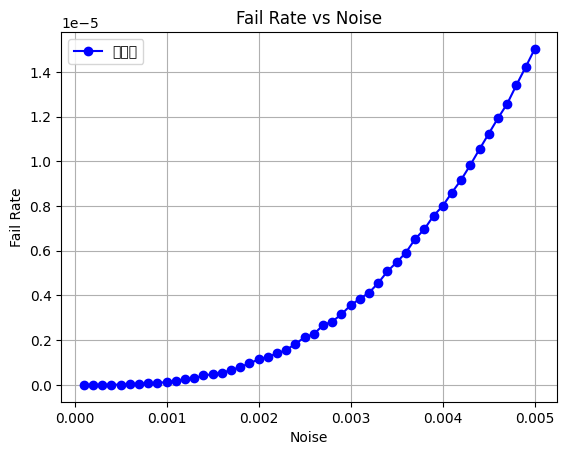

In [12]:
import numpy as np
import cupy as cp  # CuPyをインポート
import matplotlib.pyplot as plt
import traceback
import sys

# 仮の main クラスの定義（実際の実装に置き換えてください）
# from your_module import main

def main_sequential_gpu_with_chunked_sampling():
    total_num_shot = 1_000_000_000  # 総サンプル数: 10億
    num_iterations = 50  # 各ノイズレベルでのサンプリング回数
    x_list = []
    y_list = []
    chunk_size = 10_000_000  # チャンクサイズを10,000,000に設定（必要に応じて調整）
    num_chunks = total_num_shot // chunk_size  # チャンク数
    remainder_shot = total_num_shot % chunk_size  # 残りのサンプル数

    for m in range(num_iterations):
        noise = (m + 1) * 1e-4
        try:
            circuit = stim.Circuit.generated(
                "surface_code:rotated_memory_z",
                rounds=1,
                distance=3,
                after_clifford_depolarization=noise,
                after_reset_flip_probability=noise,
                before_measure_flip_probability=noise,
                before_round_data_depolarization=noise
            )
            sampler = circuit.compile_detector_sampler()

            fail = 0  # 失敗カウントの初期化

            # チャンクごとのサンプリングと処理
            for i in range(num_chunks):
                current_chunk_size = chunk_size
                if i == num_chunks - 1 and remainder_shot > 0:
                    current_chunk_size += remainder_shot

                # サンプリング結果を取得（チャンク単位）
                samples_batch, observables_batch = sampler.sample(current_chunk_size, separate_observables=True)

                # CuPy配列に変換（dtypeをuint8に変更してメモリ使用量を削減）
                samples_gpu = cp.asarray(samples_batch, dtype=cp.uint8)
                observables_gpu = cp.asarray(observables_batch, dtype=cp.uint8)

                # ベクトル化された条件判定をGPU上で実行
                is_all_false = ~cp.any(samples_gpu, axis=1)
                fail += cp.sum(is_all_false & observables_gpu[:, 0]).get()

                # メモリを解放
                del samples_gpu, observables_gpu, is_all_false
                cp.get_default_memory_pool().free_all_blocks()

                # 進捗表示（オプション）
                if (i + 1) % 10 == 0:
                    print(f"Iteration {m}, Chunk {i + 1}/{num_chunks} processed.")

            # 残りのサンプルを処理（必要に応じて）
            if remainder_shot > 0 and num_chunks == 0:
                samples_batch, observables_batch = sampler.sample(remainder_shot, separate_observables=True)

                samples_gpu = cp.asarray(samples_batch, dtype=cp.uint8)
                observables_gpu = cp.asarray(observables_batch, dtype=cp.uint8)

                is_all_false = ~cp.any(samples_gpu, axis=1)
                fail += cp.sum(is_all_false & observables_gpu[:, 0]).get()

                # メモリを解放
                del samples_gpu, observables_gpu, is_all_false
                cp.get_default_memory_pool().free_all_blocks()

            fail_rate = fail / total_num_shot
            x_list.append(noise)
            y_list.append(fail_rate)
            print(f"Iteration {m}: {fail}/{total_num_shot} = {fail_rate:.10f} (Noise: {noise})")
        except cp.cuda.memory.OutOfMemoryError as mem_err:
            print(f"m={m} でメモリ不足エラーが発生しました: {mem_err}", file=sys.stderr)
            traceback.print_exc()
        except np.core._exceptions._ArrayMemoryError as mem_err:
            print(f"m={m} でメモリ不足エラーが発生しました: {mem_err}", file=sys.stderr)
            traceback.print_exc()
        except Exception as e:
            print(f"m={m} でエラーが発生しました: {e}", file=sys.stderr)
            traceback.print_exc()

    if not x_list or not y_list:
        print("エラー: すべてのタスクが失敗したか、結果がありません。", file=sys.stderr)
        return

    # ノイズ値でソート（オプション）
    sorted_pairs = sorted(zip(x_list, y_list))

    try:
        x_list, y_list = zip(*sorted_pairs)
    except ValueError as ve:
        print(f"データのアンパック中にエラーが発生しました: {ve}", file=sys.stderr)
        return

    # プロット
    plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')
    plt.xlabel('Noise')
    plt.ylabel('Fail Rate')
    plt.title('Fail Rate vs Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

    return x_list, y_list

if __name__ == "__main__":
    x_list, y_list = main_sequential_gpu_with_chunked_sampling()

In [76]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)
    
    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [77]:
import stim
import numpy as np
from stimbposd import BPOSD

num_shots = 10000

sampler = circuit.compile_detector_sampler()
shots, observables = sampler.sample(num_shots, separate_observables=True)

decoder = BPOSD(circuit.detector_error_model(), max_bp_iters=20)

predicted_observables = decoder.decode_batch(shots)
num_mistakes = np.sum(np.any(predicted_observables != observables, axis=1))

print(f"{num_mistakes}/{num_shots}")

ModuleNotFoundError: No module named 'stimbposd'

In [17]:
# diagram = circuit.diagram("timeline-svg")
# with open("circuit_timeline.svg", "w") as f:
#     f.write(str(diagram))
# # SVGからPDFに変換
# import cairosvg
# cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

# diagram = circuit.diagram("detslice-svg")
# with open("circuit_detslice.svg", "w") as f:
#     f.write(str(diagram))
# # SVGからPDFに変換
# import cairosvg
# cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

# diagram = circuit.without_noise().diagram(
#     "detslice-with-ops-svg", 
#     tick=range(0, 100),
# )
# with open("circuit_detslice-with-ops.svg", "w") as f:
#     f.write(str(diagram))
# # SVGからPDFに変換
# import cairosvg
# cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")